# Loading model

In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
models_dir = os.path.join(Path().resolve(),'trained_models','trained_models')
models = [f for f in os.listdir(models_dir) if f.find('ipynb')==-1]
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024_10_24 17-21-39 Deep Neural Network 7RMSE
1     2024_10_24 17-31-33 Deep Neural Network 50RMSE
2     2024_10_25 12-23-03 Deep Neural Network 33RMSE
3     2024_10_25 12-23-03 Deep Neural Network asian


In [25]:
model = models[1]
model_dir = os.path.join(models_dir,model)
model_files = [f for f in os.listdir(model_dir) if f.find('ipynb')==-1]
for i,m in enumerate(model_files):
    print(f"{i}     {m}")

0     2024_10_24 17-31-33 Deep Neural Network 50RMSE insample.csv
1     2024_10_24 17-31-33 Deep Neural Network 50RMSE outsample.csv
2     2024_10_24 17-31-33 Deep Neural Network 50RMSE.pkl
3     2024_10_24 17-31-33 Deep Neural Network 50RMSE.txt


In [26]:
train_data = pd.read_csv(os.path.join(model_dir,model_files[0])).iloc[:,1:].copy()
test_data = pd.read_csv(os.path.join(model_dir,model_files[1])).iloc[:,1:].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'])
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'])
model_fit = joblib.load(os.path.join(model_dir,model_files[2]))
model_fit

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'kappa',
                                                                                        'theta',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0',
                                                                                        'barrier']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['barrier_type_name',
                                                                                        'w'])])),
                                                     ('regressor',
                                                      MLPRegressor(hidden_layer_sizes=(13,
                                                                                       13,
                                                                                       13),
                                                                   learning_rate='adaptive',
                                                                   max_iter=1000,
                                                                   solver='sgd'))]),
                           transformer=Pipeline(steps=[('StandardScaler',
                                                        StandardScaler())]))

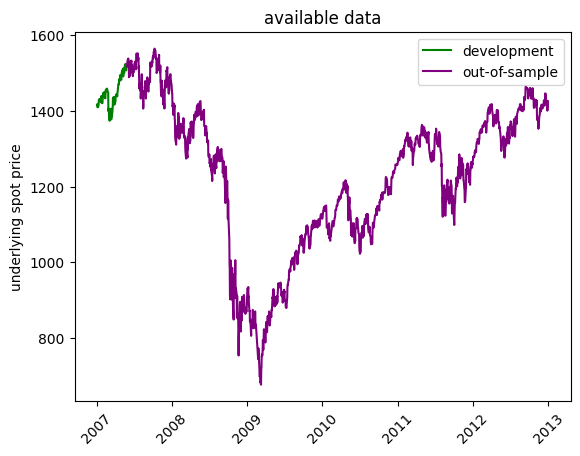

In [27]:
train_spots = train_data[['calculation_date','spot_price']].copy().set_index('calculation_date').drop_duplicates().dropna()
test_spots = test_data[['calculation_date','spot_price']].copy().set_index('calculation_date').drop_duplicates().dropna()
train_dates = pd.Series(train_spots.index)
test_dates = pd.Series(test_spots.index)
plt.figure()
plt.plot(train_spots,color='green',label='development')
plt.plot(test_spots,color='purple',label='out-of-sample')
plt.title('available data')
plt.ylabel('underlying spot price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [28]:
test_data.dtypes

spot_price                       float64
strike_price                     float64
barrier                          float64
days_to_maturity                   int64
updown                            object
outin                             object
w                                 object
barrier_type_name                 object
rebate                           float64
dividend_rate                    float64
risk_free_rate                   float64
theta                            float64
kappa                            float64
rho                              float64
eta                              float64
v0                               float64
calculation_date          datetime64[ns]
barrier_price                    float64
observed_price                   float64
outofsample_target               float64
outofsample_prediction           float64
outofsample_error                float64
dtype: object

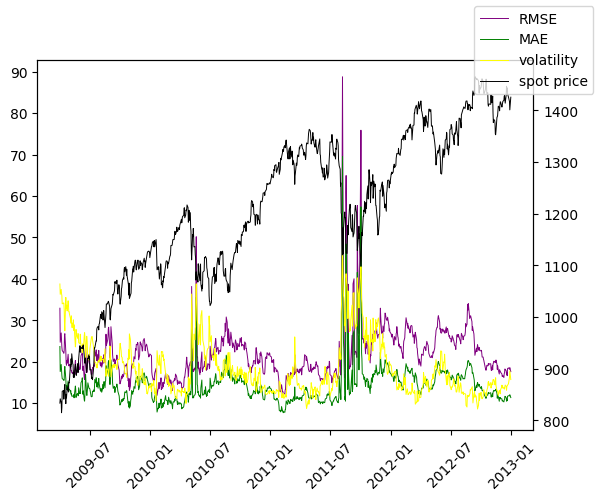

In [29]:
test_dates = test_dates[test_dates>pd.Timestamp(2009,4,1)]
test_spots = test_spots[test_spots.index.isin(test_dates)]
MAES = []
RMSES = []
vols = []
linew = 0.7

for i,date in enumerate(test_dates):
    df = test_data[test_data['calculation_date']==date].set_index('calculation_date')
    prediction = df['outofsample_prediction']
    target = df['observed_price']
    diff = prediction - target
    RMSES.append(np.sqrt(np.mean(diff**2)))
    MAES.append(np.mean(np.abs(diff)))
    vols.append(100*(float(df['v0'].unique()[0]))**(1/2))
    
fig, ax1 = plt.subplots()
MAES = np.array(MAES)
RMSES = np.array(RMSES)
vols = np.array(vols)
plt.xticks(rotation=45)
ax1.plot(test_dates,RMSES,color='purple',label='RMSE',linewidth=linew)
ax1.plot(test_dates,MAES,color='green',label='MAE',linewidth=linew)
ax1.plot(test_dates,vols,color='yellow',label='volatility',linewidth=linew)
ax2 = ax1.twinx()
ax2.plot(test_spots,color='black',label='spot price',linewidth=linew)
fig.legend()
plt.show()

# Testing

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
y = vols
X = MAES.reshape(-1,1)
reg = LinearRegression().fit(X, y)
R2 = reg.score(X,y)
b = reg.coef_[0]
print(f"R squared: {R2},",f"slope: {b}")

R squared: 0.21306836938722762, slope: 0.63367757342602


In [32]:
X = X.flatten()
lX = np.log(X)
dlX = lX[1:] - lX[:-1]
dlX = dlX.reshape(-1,1)

ly = np.log(y)
dly = ly[1:] - ly[:-1]

reg = LinearRegression().fit(dlX, dly)
R2 = reg.score(dlX,dly)
b = reg.coef_[0]
print(f"R squared: {R2},",f"slope: {b}")

R squared: 0.02122850312146196, slope: 0.10389026953294485


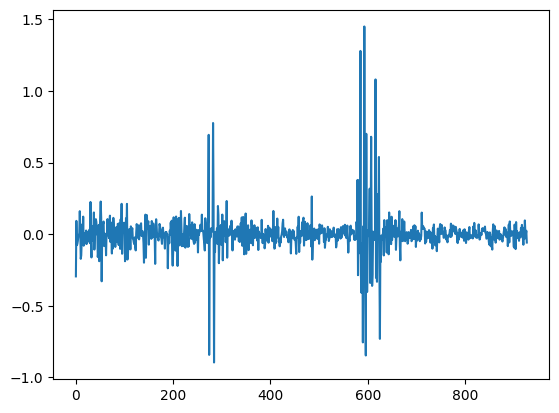

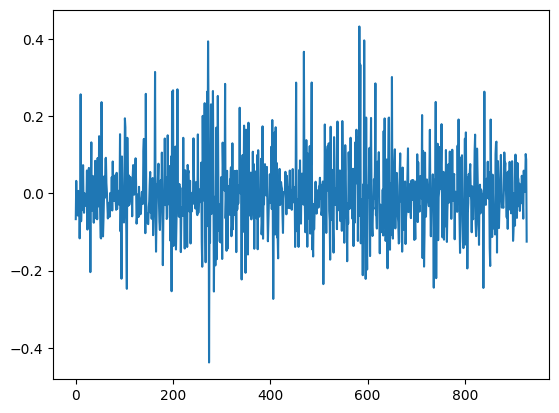

In [33]:
plt.figure()
plt.plot(dlX)
plt.show()
plt.figure()
plt.plot(dly)
plt.show()